# Training a Denoising Diffusion Probabilistic Model from Scratch

In [12]:
import os
import random
import pathlib
from typing import Optional

import glob
from PIL import Image
import numpy as np

import torch
import torch.nn.functional as F
import torch
from torch.optim import Adam, RAdam
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import multiprocessing

from torchvision import transforms 
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [4]:
# Make results fully reproducible
seed = 42
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [5]:
# Name of each GPU
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))

0 NVIDIA GeForce RTX 3060
1 NVIDIA T500


In [6]:
# Select GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
!nvidia-smi

Tue Nov 11 21:16:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA T500                    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8            N/A  / 5001W |       5MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dataset

We are going to use the Stanford Cars dataset. It consists of 196 classes of cars with a total of 16185 images. However, we do not need any label, nor a test dataset. Additionally, we are going to resize the images to `64x64` for easier processing.

Note that the original dataset [https://ai.stanford.edu/~jkrause/cars/car_dataset.html](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) is not available anymore.
Instead, we can download it from Kaggle or HuggingFace.

- I downloaded it from [https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset](https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset) manually and unzipped it to `./data`. Unfortunately, the programmagtic `kagglehub` option didn't work for me.
- The alternative would be to download it from HuggingFace: [https://huggingface.co/datasets/tanganke/stanford_cars](https://huggingface.co/datasets/tanganke/stanford_cars); in that case, either the structure of the dataset or the code which instantiates the dataloaders need to be modified.

I have manually arranged this structure in `./data`:

```
data/
    stanford_cars/
        train/
            00001.jpg
            ...
        test/
            00001.jpg
            ...
        devkit/ (unused, since we don't need annotations)
            car_test_annos.mat
            car_train_annos.mat
            ...
```

This section builds a Pytorch Dataset & Dataloader based on the images.

In [25]:
IMG_SIZE = 64
BATCH_SIZE = 100

In [26]:
class CarImagesDataset(Dataset):
    def __init__(
            self,
            root_dir: str | pathlib.Path,
            transform: Optional[transforms.Compose] = None
        ):
        self.transform = transform
        # Find all jpg files in the directory
        self.image_paths = list(pathlib.Path(root_dir).glob("*.jpg"))
        
    def __len__(self) -> int:
        return len(self.image_paths)
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
            
        return image, 0  # Return dummy label since we don't need it

In [27]:
def get_dataset(path: str | pathlib.Path) -> Dataset:
    data_transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            # Flip horizontally with probability 50%
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            # Scale data to [-1,1] 
            transforms.Normalize(0.5, 0.5)
        ]
    )
    
    # Use custom dataset for your flat folder structure
    train = CarImagesDataset(
        root_dir=pathlib.Path(path) / "train", 
        transform=data_transform
    )

    test = CarImagesDataset(
        root_dir=pathlib.Path(path) / "test", 
        transform=data_transform
    )
    
    return torch.utils.data.ConcatDataset([train, test])

In [28]:
data = get_dataset("./data/stanford_cars")
dataloader = DataLoader(
    data, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=False, 
    pin_memory=True, 
    num_workers=multiprocessing.cpu_count(),
    persistent_workers=True
)

In [29]:
def display_sequence(imgs, dpi: int = 75, nrow: int = 8):    
    fig, sub = plt.subplots(dpi=dpi)
    sub.imshow(
        np.transpose(
            make_grid(
                imgs, 
                padding=0,
                normalize=True,
                nrow=nrow,
            ).cpu(),
            (1,2,0)
        )
    )
    _ = sub.axis("off")
    
    return fig

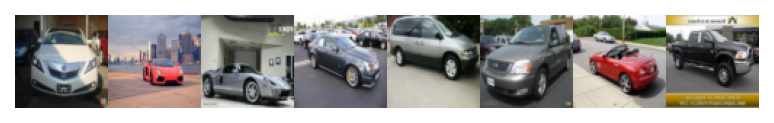

In [30]:
# Get a batch
batch, _ = next(iter(dataloader))
# Display it
_ = display_sequence(batch[:8], dpi=150)